In [83]:
import os
import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

%matplotlib inline

In [17]:
path_name = "/Users/betashort/Downloads/16000_pcm_speeches/"

In [18]:
os.listdir(path_name)

['Jens_Stoltenberg',
 'Benjamin_Netanyau',
 '.DS_Store',
 'other',
 '_background_noise_',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela',
 'tf_Wav_reader.py']

In [43]:
speaker_label = {'Jens_Stoltenberg' : 0,
                 'Benjamin_Netanyau': 1,                 
                 'Julia_Gillard' : 2,
                 'Magaret_Tarcher' : 3,
                 'Nelson_Mandela' : 4,
                }

0~1499

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim

In [271]:
class Audio_Datasets(torch.utils.data.Dataset):
    
    def __init__(self, file_label_list):
        self.path = file_label_list
        self.sr = 22000
    
    def __len__(self):
        
        return len(self.path)
    
    def __getitem__(self, idx):
        data, _ = librosa.load(self.path[idx][0])
        data = data[:self.sr]
        data = data.reshape(1, self.sr)
        label = np.array(self.path[idx][1])
        
        return data, label

In [272]:
def Read_file_label(speaker_label):
    file_label_list = []
    file_list = []
    label_list = []
    
    for label in speaker_label.keys():
        n_file = len(glob.glob(os.path.join(path_name, list(speaker_label.keys())[0])+"/*.wav"))
        
        for i in range(n_file):
            
            file_label_list.append((os.path.join(path_name, label, f"{i}.wav"), speaker_label[label]))
            
            file_list.append(os.path.join(path_name, label, f"{i}.wav"))
            label_list.append(speaker_label[label])
            
    return file_label_list, file_list, label_list

In [273]:
file_label_list, file_list, label_list = Read_file_label(speaker_label)

In [274]:
dataset = Audio_Datasets(file_label_list)

In [275]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=120)

In [276]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [277]:
X_train, X_valid, y_train, y_valid = train_test_split(file_list, label_list, test_size=0.2)

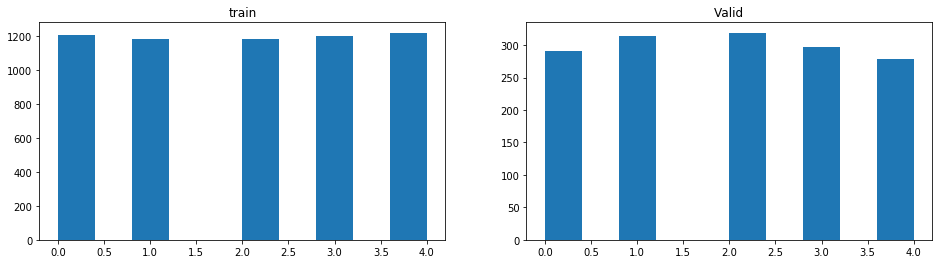

In [278]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train)
plt.title("train")
plt.subplot(1, 2, 2)
plt.hist(y_valid)
plt.title("Valid")
plt.show()

In [279]:
train = [(X_train[idx], y_train[idx]) for idx in range(len(X_train))]
valid = [(X_valid[idx], y_valid[idx]) for idx in range(len(X_valid))]

In [280]:
train_loader = torch.utils.data.DataLoader(Audio_Datasets(train), batch_size=120)
valid_loader = torch.utils.data.DataLoader(Audio_Datasets(valid), batch_size=120)

# Network

In [303]:
class Net1D(nn.Module):
    def __init__(self):
        super(Net1D,self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv1d(1, 8, kernel_size=10, stride=1),
                                   nn.BatchNorm1d(8),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=10, stride=2),
                                  )
        
        self.conv2 = nn.Sequential(nn.Conv1d(8, 32, kernel_size=100, stride=1),
                                   nn.BatchNorm1d(32),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=100, stride=2),
                                  )
        
        self.conv3 = nn.Sequential(nn.Conv1d(32, 64, kernel_size=300, stride=1),
                                   nn.BatchNorm1d(64),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=300, stride=2),
                                  )
        
        self.conv4 = nn.Sequential(nn.Conv1d(64, 128, kernel_size=500, stride=1),
                                   nn.BatchNorm1d(128),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=500, stride=2),
                                  )
        
        
        self.dense = nn.Sequential(nn.Linear(89728, 512),
                                   nn.ReLU(),
                                   nn.Dropout(),
                                   nn.Linear(512,128),
                                   nn.ReLU(),
                                   nn.Dropout(),
                                   nn.Linear(128, 5),
                                  )


    def forward(self,x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0),-1)
        x = self.dense(x)

        return x
    
    def check_size(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0),-1)

        return x

In [304]:
device='cuda' if torch.cuda.is_available() else 'cpu'

model = Net1D().to(device)

size_check = torch.FloatTensor(10, 1, 22000)
print(model.check_size(size_check).size())

torch.Size([10, 89728])


In [305]:
model = Net1D().to(device)

#weights = torch.tensor([1]).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

In [329]:
#==== 学習 ====
def learning(train_loader, val_loader, num_epochs=10):
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        valid_loss = 0
        valid_acc = 0
        
        
        #==== 学習 ====
        net.train()
        
        for images, labels in train_loader:
            #==== deviceに渡す
            images = images.to(device)
            labels = labels.to(device)
            
            #==== Optimizerの初期化 ====
            optimizer.zero_grad()
            
            #==== forward processing ====
            outputs = model(images)
            
            #==== Loss calcuration ====
            loss = criterion(outputs, labels)
            
            #==== backward processing ====
            loss.backward()
            
            #==== update optimizer ====
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy_score(labels.cpu().detach().clone().numpy(), 
                                        np.argmax(outputs.cpu().detach().clone().numpy(), axis=1),
                                        )
            
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_acc / len(train_loader.dataset)
        
        #==== 検証 =====
        net.eval()
        
        #重みを変えさせない
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                valid_acc += accuracy_score(labels.cpu().detach().clone().numpy(), 
                                            np.argmax(outputs.cpu().detach().clone().numpy(), axis=1),
                                           )
                
        avg_valid_loss = valid_loss / len(valid_loader.dataset)
        avg_valid_acc = valid_acc / len(valid_loader.dataset)
        
        print(f"=====  epoch: {epoch+1} ===== \
        \n train_loss: {avg_train_loss}, valid_loss: {avg_valid_loss} \
        \n train_acc: {avg_train_acc}, valid_acc: {avg_valid_acc}")
        
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        valid_loss_list.append(avg_valid_loss)
        valid_acc_list.append(avg_valid_acc)
        
    loss_list = [train_loss_list, valid_loss_list]
    acc_list = [train_acc_list, valid_acc_list]
    
    return loss_list, acc_list

In [330]:
loss_list, acc_list = learning(train_loader, valid_loader)

KeyboardInterrupt: 

In [326]:
for images, labels in train_loader:
    print(labels.cpu().detach().clone().numpy())
    outputs = model(images)
    a = outputs.cpu().detach().clone().numpy()
    break

[2 4 0 4 3 1 0 4 1 1 3 1 2 2 0 1 3 1 3 2 3 1 2 0 1 3 1 0 4 0 0 3 2 2 4 1 1
 3 0 1 2 0 0 4 4 2 4 3 1 0 3 1 0 4 1 3 4 1 0 1 2 0 4 4 0 3 4 3 0 2 4 2 1 1
 1 2 1 4 0 2 1 4 3 0 3 3 0 1 2 0 3 3 4 1 2 4 4 3 2 3 3 3 1 0 2 2 4 0 4 3 1
 4 2 3 1 1 1 3 1 2]


In [328]:
np.argmax(a, axis=1)

array([0, 1, 2, 0, 2, 3, 3, 0, 2, 2, 0, 1, 2, 1, 2, 3, 1, 1, 1, 3, 1, 1,
       2, 2, 0, 3, 0, 2, 3, 2, 2, 3, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 1, 2,
       2, 3, 1, 1, 0, 3, 3, 2, 0, 0, 1, 0, 2, 2, 3, 1, 0, 2, 1, 1, 1, 1,
       3, 0, 2, 1, 4, 3, 3, 2, 2, 0, 2, 3, 2, 3, 2, 3, 1, 2, 3, 0, 0, 2,
       0, 0, 4, 3, 1, 0, 2, 0, 3, 1, 2, 1, 3, 0, 0, 1, 3, 1, 0, 2, 1, 2,
       2, 3, 3, 2, 3, 0, 0, 1, 3, 0])